# Data and Train Traffic Signs

## Check GPU and Install Dependencies

In [ ]:
# @title Check GPU
print("=" * 60)
print("Checking GPU availability...")
print("=" * 60)

import torch
import sys

if torch.cuda.is_available():
  print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
  print(f" GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
  # Verify with nvidia-smi
  !nvidia-smi -L
else:
  print("⚠ No GPU detected. Training will be slower on CPU.")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")



Checking GPU availability...
⚠ No GPU detected. Training will be slower on CPU.

Using device: cpu


In [ ]:
# @title Install required packages (minimal)
print("\n" + "=" * 60)
print("Installing dependencies...")
print("=" * 60)
!pip install -q torch torchvision matplotlib scikit-learn tqdm Pillow

print("✓ Dependencies installed successfully")


Installing dependencies...
✓ Dependencies installed successfully


## Download and Extract GTSRB Dataset

In [ ]:
print("\n" + "=" * 60)
print("Downloading GTSRB Dataset")
print("=" * 60)
print("Dataset: German Traffic Sign Recognition Benchmark")
print("Source: https://benchmark.ini.rub.de/gtsrb_dataset.html")
print("Kaggle mirror: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print()

import os
import zipfile
import urllib.request
from pathlib import Path


Dataset: German Traffic Sign Recognition Benchmark
Source: https://benchmark.ini.rub.de/gtsrb_dataset.html
Kaggle mirror: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign



In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Create data directory
DATA_DIR = Path('/content/drive/MyDrive/gtsrb_data')
DATA_DIR.mkdir(exist_ok=True)

In [ ]:
DATASET_URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"
TEST_URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip"
TEST_LABELS_URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip"

def download_file(url, dest_path):
  """Download file with progress bar"""
  if not dest_path.exists():
    print(f"Downloading {dest_path.name}...")
    urllib.request.urlretrieve(url, dest_path)
    print(f"✓ Downloaded {dest_path.name}")
  else:
    print(f"✓ {dest_path.name} already exists")

In [ ]:
# @title Download files
train_zip = DATA_DIR / 'train.zip'
test_zip = DATA_DIR / 'test.zip'
test_labels_zip = DATA_DIR / 'test_labels.zip'

download_file(DATASET_URL, train_zip)
download_file(TEST_URL, test_zip)
download_file(TEST_LABELS_URL, test_labels_zip)

✓ Downloaded train.zip
✓ Downloaded test.zip
✓ Downloaded test_labels.zip


In [ ]:
# @title Extract archives
print("\nExtracting archives...")
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
  zip_ref.extractall(DATA_DIR / 'train_raw')

with zipfile.ZipFile(test_zip, 'r') as zip_ref:
  zip_ref.extractall(DATA_DIR / 'test_raw')

with zipfile.ZipFile(test_labels_zip, 'r') as zip_ref:
  zip_ref.extractall(DATA_DIR / 'test_labels')

print("✓ Dataset extracted successfully")
print(f"✓ Dataset location: {DATA_DIR}")


Extracting archives...
✓ Dataset extracted successfully
✓ Dataset location: /content/drive/MyDrive/gtsrb_data


## Prepare Dataset

In [ ]:
print("\n" + "=" * 60)
print("Preparing GTSRB dataset for PyTorch")
print("=" * 60)

import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import shutil


Preparing GTSRB dataset for PyTorch


In [ ]:
# Organize training data
TRAIN_DIR = DATA_DIR / 'train_raw' / 'GTSRB' / 'Final_Training' / 'Images'
ORGANIZED_TRAIN = DATA_DIR / 'train'
ORGANIZED_TRAIN.mkdir(exist_ok=True)

In [ ]:
# GTSRB has 43 classes (00000-00042)
NUM_CLASSES = 43

print(f"Organizing {NUM_CLASSES} classes...")
for class_id in range(NUM_CLASSES):
  src_folder = TRAIN_DIR / f'{class_id:05d}'
  if src_folder.exists():
    dest_folder = ORGANIZED_TRAIN / str(class_id)
  if not dest_folder.exists():
    shutil.copytree(src_folder, dest_folder)

Organizing 43 classes...


In [ ]:
# Organize test data using GT file
TEST_DIR = DATA_DIR / 'test_raw' / 'GTSRB' / 'Final_Test' / 'Images'
ORGANIZED_TEST = DATA_DIR / 'test'
GT_FILE = DATA_DIR / 'test_labels' / 'GT-final_test.csv'

In [ ]:
# Read ground truth
gt_data = pd.read_csv(GT_FILE, sep=';')
print(f"Test images: {len(gt_data)}")

for class_id in range(NUM_CLASSES):
  (ORGANIZED_TEST / str(class_id)).mkdir(parents=True, exist_ok=True)

Test images: 12630


In [ ]:
# Copy test images to class folders
for idx, row in gt_data.iterrows():
  filename = row['Filename']
  class_id = row['ClassId']
  src = TEST_DIR / filename
  dest = ORGANIZED_TEST / str(class_id) / filename
  if src.exists() and not dest.exists():
    shutil.copy(src, dest)

print(f"✓ Dataset organized")
print(f" Training: {ORGANIZED_TRAIN}")
print(f" Test: {ORGANIZED_TEST}")

✓ Dataset organized
 Training: /content/drive/MyDrive/gtsrb_data/train
 Test: /content/drive/MyDrive/gtsrb_data/test


## Define CNN Architecture

In [ ]:
print("\n" + "=" * 60)
print("Defining CNN Architecture")
print("=" * 60)

import torch.nn as nn
import torch.nn.functional as F

class TinyTrafficSignCNN(nn.Module):
  """
  Minimal CNN for GTSRB Classification
  Architecture: 3 Conv layers + 2 FC layers
  Parameters: ~150k (suitable for Colab free)
  Input: 32x32 RGB images
  Output: 43 classes
  """
  def __init__(self, num_classes=43):
    super(TinyTrafficSignCNN, self).__init__()
    # Convolutional layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 32x32 -> 32x32
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 16x16 -> 16x16
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 8x8 -> 8x8
    self.bn3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4

    # Fully connected layers
    self.fc1 = nn.Linear(128 * 4 * 4, 256)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, num_classes)

  def forward(self, x):
    # Conv block 1
    x = self.pool1(F.relu(self.bn1(self.conv1(x))))

    # Conv block 2
    x = self.pool2(F.relu(self.bn2(self.conv2(x))))

    # Conv block 3
    x = self.pool3(F.relu(self.bn3(self.conv3(x))))

    # Flatten
    x = x.view(-1, 128 * 4 * 4)

    # FC layers
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x



Defining CNN Architecture


In [ ]:
# Instantiate model
model = TinyTrafficSignCNN(num_classes=NUM_CLASSES).to(device)

In [ ]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model created successfully")
print(f" Total parameters: {total_params:,}")
print(f" Trainable parameters: {trainable_params:,}")
print(f"\nModel Architecture:")
print(model)

✓ Model created successfully
 Total parameters: 629,291
 Trainable parameters: 629,291

Model Architecture:
TinyTrafficSignCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): 

## Data Loaders with Augmentation

In [ ]:
print("\n" + "=" * 60)
print("Setting up data loaders with augmentation")
print("=" * 60)

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Image size for GTSRB
IMG_SIZE = 32
BATCH_SIZE = 64


Setting up data loaders with augmentation


In [ ]:
# Data augmentation for training
train_transform = transforms.Compose([
  transforms.Resize((IMG_SIZE, IMG_SIZE)),
  transforms.RandomRotation(15), # Slight rotation
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
  transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [ ]:
# No augmentation for validation/test
test_transform = transforms.Compose([
  transforms.Resize((IMG_SIZE, IMG_SIZE)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load datasets
train_dataset = datasets.ImageFolder(ORGANIZED_TRAIN, transform=train_transform)
test_dataset = datasets.ImageFolder(ORGANIZED_TEST, transform=test_transform)

In [ ]:
# Split train into train/val (90/10)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [ ]:
# Create data loaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✓ Data loaders created")
print(f" Training samples: {len(train_subset)}")
print(f" Validation samples: {len(val_subset)}")
print(f" Test samples: {len(test_dataset)}")
print(f" Batch size: {BATCH_SIZE}")
print(f" Number of classes: {NUM_CLASSES}")

✓ Data loaders created
 Training samples: 35288
 Validation samples: 3921
 Test samples: 12630
 Batch size: 64
 Number of classes: 43


## Training Setup

In [ ]:
print("\n" + "=" * 60)
print("Training Configuration")
print("=" * 60)

import torch.optim as optim
from tqdm import tqdm

# Hyperparameters
LEARNING_RATE = 1e-3
NUM_EPOCHS = 12
SAVE_PATH = '/content/drive/MyDrive/traffic_sign_cnn.pt'

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

print(f"✓ Training setup complete")
print(f" Epochs: {NUM_EPOCHS}")
print(f" Learning rate: {LEARNING_RATE}")
print(f" Optimizer: Adam")
print(f" Loss function: CrossEntropyLoss")
print(f" Scheduler: ReduceLROnPlateau")


Training Configuration
✓ Training setup complete
 Epochs: 12
 Learning rate: 0.001
 Optimizer: Adam
 Loss function: CrossEntropyLoss
 Scheduler: ReduceLROnPlateau


## Training Loop

In [ ]:
print("\n" + "=" * 60)
print("Starting Training")
print("=" * 60)

# Training history
history = {
  'train_loss': [],
  'train_acc': [],
  'val_loss': [],
  'val_acc': []
}

best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
  print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
  print("-" * 40)
  # Training phase
  model.train()
  train_loss = 0.0
  train_correct = 0
  train_total = 0

  train_pbar = tqdm(train_loader, desc='Training', leave=False)
  for images, labels in train_pbar:
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward pass
      loss.backward()
      optimizer.step()

      # Statistics
      train_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      train_total += labels.size(0)
      train_correct += (predicted == labels).sum().item()

      # Update progress bar
      train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

  avg_train_loss = train_loss / len(train_loader)
  train_accuracy = 100 * train_correct / train_total

  # Validation phase
  model.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      val_pbar = tqdm(val_loader, desc='Validation', leave=False)
      for images, labels in val_pbar:
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          loss = criterion(outputs, labels)

          val_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()

  avg_val_loss = val_loss / len(val_loader)
  val_accuracy = 100 * val_correct / val_total

  # Update scheduler
  scheduler.step(avg_val_loss)

  # Save best model
  if val_accuracy > best_val_acc:
      best_val_acc = val_accuracy
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_acc': val_accuracy,
      }, SAVE_PATH)
      print(f"✓ Saved best model (val_acc: {val_accuracy:.2f}%)")

  # Record history
  history['train_loss'].append(avg_train_loss)
  history['train_acc'].append(train_accuracy)
  history['val_loss'].append(avg_val_loss)
  history['val_acc'].append(val_accuracy)

  # Print epoch results
  print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
  print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

print("\n" + "=" * 60)
print("Training Complete!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Model saved to: {SAVE_PATH}")
print("=" * 60)



Starting Training

Epoch 1/12
----------------------------------------


✓ Saved best model (val_acc: 79.01%)
Train Loss: 1.2236 | Train Acc: 58.42%
Val Loss: 0.6558 | Val Acc: 79.01%

Epoch 2/12
----------------------------------------


✓ Saved best model (val_acc: 89.06%)
Train Loss: 0.7068 | Train Acc: 75.65%
Val Loss: 0.3627 | Val Acc: 89.06%

Epoch 3/12
----------------------------------------


✓ Saved best model (val_acc: 92.22%)
Train Loss: 0.4920 | Train Acc: 83.56%
Val Loss: 0.2438 | Val Acc: 92.22%

Epoch 4/12
----------------------------------------


✓ Saved best model (val_acc: 95.66%)
Train Loss: 0.3641 | Train Acc: 87.91%
Val Loss: 0.1506 | Val Acc: 95.66%

Epoch 5/12
----------------------------------------


✓ Saved best model (val_acc: 96.63%)
Train Loss: 0.2848 | Train Acc: 90.56%
Val Loss: 0.1205 | Val Acc: 96.63%

Epoch 6/12
----------------------------------------


✓ Saved best model (val_acc: 96.79%)
Train Loss: 0.2551 | Train Acc: 91.71%
Val Loss: 0.1106 | Val Acc: 96.79%

Epoch 7/12
----------------------------------------


✓ Saved best model (val_acc: 97.63%)
Train Loss: 0.2163 | Train Acc: 92.95%
Val Loss: 0.0790 | Val Acc: 97.63%

Epoch 8/12
----------------------------------------


Train Loss: 0.1889 | Train Acc: 93.83%
Val Loss: 0.0792 | Val Acc: 97.63%

Epoch 9/12
----------------------------------------


✓ Saved best model (val_acc: 97.83%)
Train Loss: 0.1724 | Train Acc: 94.29%
Val Loss: 0.0784 | Val Acc: 97.83%

Epoch 10/12
----------------------------------------


✓ Saved best model (val_acc: 98.01%)
Train Loss: 0.1598 | Train Acc: 94.77%
Val Loss: 0.0678 | Val Acc: 98.01%

Epoch 11/12
----------------------------------------


Train Loss: 0.1439 | Train Acc: 95.33%
Val Loss: 0.0679 | Val Acc: 97.78%

Epoch 12/12
----------------------------------------


✓ Saved best model (val_acc: 98.29%)
Train Loss: 0.1412 | Train Acc: 95.58%
Val Loss: 0.0599 | Val Acc: 98.29%

Training Complete!
Best validation accuracy: 98.29%
Model saved to: /content/drive/MyDrive/traffic_sign_cnn.pt


## Evaluation on Test Set

In [48]:
print("\n" + "=" * 60)
print("Evaluating on Test Set")
print("=" * 60)

# Load best model
checkpoint = torch.load(SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
  for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    test_accuracy = 100 * test_correct / test_total
    print(f"\n✓ Test Accuracy: {test_accuracy:.2f}%")


Evaluating on Test Set


Testing:   1%|          | 2/198 [00:01<02:40,  1.22it/s]


✓ Test Accuracy: 93.75%

✓ Test Accuracy: 96.88%


Testing:   2%|▏         | 4/198 [00:02<01:16,  2.52it/s]


✓ Test Accuracy: 97.92%

✓ Test Accuracy: 98.05%


Testing:   3%|▎         | 6/198 [00:02<00:59,  3.21it/s]


✓ Test Accuracy: 98.44%

✓ Test Accuracy: 98.70%


Testing:   4%|▍         | 8/198 [00:03<00:54,  3.47it/s]


✓ Test Accuracy: 98.88%

✓ Test Accuracy: 99.02%


Testing:   5%|▌         | 10/198 [00:04<00:48,  3.87it/s]


✓ Test Accuracy: 99.13%

✓ Test Accuracy: 99.22%


Testing:   6%|▌         | 12/198 [00:04<00:48,  3.82it/s]


✓ Test Accuracy: 99.15%

✓ Test Accuracy: 99.22%


Testing:   7%|▋         | 13/198 [00:05<00:59,  3.11it/s]


✓ Test Accuracy: 99.28%

✓ Test Accuracy: 99.33%


Testing:   8%|▊         | 16/198 [00:05<00:47,  3.81it/s]


✓ Test Accuracy: 99.38%

✓ Test Accuracy: 99.41%


Testing:   9%|▊         | 17/198 [00:06<00:51,  3.49it/s]


✓ Test Accuracy: 99.45%


Testing:   9%|▉         | 18/198 [00:06<00:51,  3.51it/s]


✓ Test Accuracy: 99.48%


Testing:  10%|█         | 20/198 [00:06<00:47,  3.78it/s]


✓ Test Accuracy: 99.42%

✓ Test Accuracy: 99.45%


Testing:  11%|█         | 21/198 [00:07<00:50,  3.50it/s]


✓ Test Accuracy: 99.48%


Testing:  11%|█         | 22/198 [00:07<00:46,  3.77it/s]


✓ Test Accuracy: 99.50%


Testing:  12%|█▏        | 24/198 [00:08<00:50,  3.45it/s]


✓ Test Accuracy: 99.52%

✓ Test Accuracy: 99.54%


Testing:  13%|█▎        | 26/198 [00:08<00:48,  3.54it/s]


✓ Test Accuracy: 99.56%

✓ Test Accuracy: 99.58%


Testing:  14%|█▍        | 28/198 [00:09<00:45,  3.78it/s]


✓ Test Accuracy: 99.54%

✓ Test Accuracy: 99.50%


Testing:  15%|█▌        | 30/198 [00:09<00:48,  3.46it/s]


✓ Test Accuracy: 99.52%

✓ Test Accuracy: 99.11%


Testing:  16%|█▌        | 32/198 [00:10<00:46,  3.59it/s]


✓ Test Accuracy: 98.74%

✓ Test Accuracy: 98.39%


Testing:  17%|█▋        | 33/198 [00:10<00:52,  3.14it/s]


✓ Test Accuracy: 98.25%


Testing:  17%|█▋        | 34/198 [00:11<00:51,  3.19it/s]


✓ Test Accuracy: 98.12%


Testing:  18%|█▊        | 35/198 [00:11<01:08,  2.36it/s]


✓ Test Accuracy: 98.04%


Testing:  18%|█▊        | 36/198 [00:12<01:02,  2.57it/s]


✓ Test Accuracy: 97.96%


Testing:  19%|█▊        | 37/198 [00:12<01:10,  2.29it/s]


✓ Test Accuracy: 97.76%


Testing:  19%|█▉        | 38/198 [00:13<01:03,  2.54it/s]


✓ Test Accuracy: 97.78%


Testing:  20%|██        | 40/198 [00:13<00:54,  2.92it/s]


✓ Test Accuracy: 97.68%

✓ Test Accuracy: 97.54%


Testing:  21%|██        | 41/198 [00:14<01:11,  2.19it/s]


✓ Test Accuracy: 97.60%


Testing:  21%|██        | 42/198 [00:14<00:59,  2.62it/s]


✓ Test Accuracy: 97.66%


Testing:  22%|██▏       | 44/198 [00:15<00:51,  2.96it/s]


✓ Test Accuracy: 97.71%

✓ Test Accuracy: 97.73%


Testing:  23%|██▎       | 46/198 [00:16<00:48,  3.11it/s]


✓ Test Accuracy: 97.78%

✓ Test Accuracy: 97.79%


Testing:  24%|██▍       | 48/198 [00:16<00:41,  3.60it/s]


✓ Test Accuracy: 97.84%

✓ Test Accuracy: 97.88%


Testing:  25%|██▌       | 50/198 [00:17<00:39,  3.72it/s]


✓ Test Accuracy: 97.93%

✓ Test Accuracy: 97.97%


Testing:  26%|██▋       | 52/198 [00:17<00:38,  3.75it/s]


✓ Test Accuracy: 98.01%

✓ Test Accuracy: 98.05%


Testing:  27%|██▋       | 54/198 [00:18<00:35,  4.04it/s]


✓ Test Accuracy: 98.08%

✓ Test Accuracy: 98.12%


Testing:  28%|██▊       | 55/198 [00:18<00:45,  3.15it/s]


✓ Test Accuracy: 98.15%

✓ Test Accuracy: 98.19%


Testing:  29%|██▉       | 57/198 [00:19<00:42,  3.35it/s]


✓ Test Accuracy: 98.19%

✓ Test Accuracy: 98.22%


Testing:  30%|███       | 60/198 [00:19<00:34,  3.99it/s]


✓ Test Accuracy: 98.25%

✓ Test Accuracy: 98.28%


Testing:  31%|███       | 61/198 [00:20<00:40,  3.42it/s]


✓ Test Accuracy: 98.31%

✓ Test Accuracy: 98.34%


Testing:  32%|███▏      | 63/198 [00:20<00:37,  3.62it/s]


✓ Test Accuracy: 98.36%

✓ Test Accuracy: 98.39%


Testing:  33%|███▎      | 66/198 [00:21<00:33,  3.90it/s]


✓ Test Accuracy: 98.41%

✓ Test Accuracy: 98.44%


Testing:  34%|███▍      | 67/198 [00:21<00:36,  3.61it/s]


✓ Test Accuracy: 98.37%

✓ Test Accuracy: 98.28%


Testing:  35%|███▌      | 70/198 [00:22<00:31,  4.04it/s]


✓ Test Accuracy: 98.21%

✓ Test Accuracy: 98.19%


Testing:  36%|███▋      | 72/198 [00:23<00:29,  4.23it/s]


✓ Test Accuracy: 98.06%

✓ Test Accuracy: 97.94%


Testing:  37%|███▋      | 74/198 [00:23<00:28,  4.30it/s]


✓ Test Accuracy: 97.67%

✓ Test Accuracy: 97.55%


Testing:  38%|███▊      | 76/198 [00:24<00:33,  3.60it/s]


✓ Test Accuracy: 97.44%

✓ Test Accuracy: 97.39%


Testing:  39%|███▉      | 77/198 [00:24<00:44,  2.69it/s]


✓ Test Accuracy: 97.34%


Testing:  39%|███▉      | 78/198 [00:25<00:43,  2.78it/s]


✓ Test Accuracy: 97.34%


Testing:  40%|████      | 80/198 [00:26<01:00,  1.95it/s]


✓ Test Accuracy: 97.33%

✓ Test Accuracy: 97.29%


Testing:  41%|████      | 81/198 [00:27<01:04,  1.83it/s]


✓ Test Accuracy: 97.22%


Testing:  41%|████▏     | 82/198 [00:27<00:53,  2.17it/s]


✓ Test Accuracy: 97.20%


Testing:  42%|████▏     | 84/198 [00:28<00:42,  2.67it/s]


✓ Test Accuracy: 97.16%

✓ Test Accuracy: 97.17%


Testing:  43%|████▎     | 86/198 [00:29<00:43,  2.59it/s]


✓ Test Accuracy: 97.11%

✓ Test Accuracy: 97.11%


Testing:  44%|████▍     | 88/198 [00:29<00:38,  2.86it/s]


✓ Test Accuracy: 97.05%

✓ Test Accuracy: 96.88%


Testing:  45%|████▌     | 90/198 [00:30<00:34,  3.12it/s]


✓ Test Accuracy: 96.77%

✓ Test Accuracy: 96.61%


Testing:  46%|████▌     | 91/198 [00:31<00:43,  2.44it/s]


✓ Test Accuracy: 96.48%

✓ Test Accuracy: 96.33%


Testing:  47%|████▋     | 94/198 [00:31<00:29,  3.51it/s]


✓ Test Accuracy: 96.29%

✓ Test Accuracy: 96.23%


Testing:  48%|████▊     | 95/198 [00:32<00:34,  2.99it/s]


✓ Test Accuracy: 96.25%

✓ Test Accuracy: 96.24%


Testing:  49%|████▉     | 97/198 [00:32<00:30,  3.29it/s]


✓ Test Accuracy: 96.26%

✓ Test Accuracy: 96.25%


Testing:  50%|█████     | 99/198 [00:33<00:28,  3.48it/s]


✓ Test Accuracy: 96.26%

✓ Test Accuracy: 96.28%


Testing:  52%|█████▏    | 102/198 [00:34<00:23,  4.02it/s]


✓ Test Accuracy: 96.32%

✓ Test Accuracy: 96.35%


Testing:  53%|█████▎    | 104/198 [00:34<00:23,  4.06it/s]


✓ Test Accuracy: 96.39%

✓ Test Accuracy: 96.42%


Testing:  54%|█████▎    | 106/198 [00:35<00:23,  3.90it/s]


✓ Test Accuracy: 96.01%

✓ Test Accuracy: 96.03%


Testing:  54%|█████▍    | 107/198 [00:35<00:27,  3.29it/s]


✓ Test Accuracy: 96.06%

✓ Test Accuracy: 96.08%


Testing:  56%|█████▌    | 110/198 [00:36<00:21,  4.16it/s]


✓ Test Accuracy: 96.12%

✓ Test Accuracy: 96.15%


Testing:  57%|█████▋    | 112/198 [00:36<00:21,  4.01it/s]


✓ Test Accuracy: 96.17%

✓ Test Accuracy: 96.21%


Testing:  58%|█████▊    | 114/198 [00:37<00:19,  4.21it/s]


✓ Test Accuracy: 96.21%

✓ Test Accuracy: 96.22%


Testing:  58%|█████▊    | 115/198 [00:37<00:25,  3.30it/s]


✓ Test Accuracy: 96.22%

✓ Test Accuracy: 96.11%


Testing:  60%|█████▉    | 118/198 [00:38<00:19,  4.16it/s]


✓ Test Accuracy: 95.81%

✓ Test Accuracy: 95.58%


Testing:  60%|██████    | 119/198 [00:38<00:22,  3.54it/s]


✓ Test Accuracy: 95.58%

✓ Test Accuracy: 95.61%


Testing:  62%|██████▏   | 122/198 [00:39<00:19,  3.93it/s]


✓ Test Accuracy: 95.58%

✓ Test Accuracy: 95.61%


Testing:  63%|██████▎   | 124/198 [00:40<00:18,  4.10it/s]


✓ Test Accuracy: 95.59%

✓ Test Accuracy: 95.63%


Testing:  63%|██████▎   | 125/198 [00:40<00:25,  2.88it/s]


✓ Test Accuracy: 95.66%


Testing:  64%|██████▎   | 126/198 [00:40<00:23,  3.12it/s]


✓ Test Accuracy: 95.70%


Testing:  64%|██████▍   | 127/198 [00:41<00:26,  2.68it/s]


✓ Test Accuracy: 95.72%


Testing:  65%|██████▍   | 128/198 [00:41<00:23,  3.02it/s]


✓ Test Accuracy: 95.75%


Testing:  66%|██████▌   | 130/198 [00:42<00:21,  3.12it/s]


✓ Test Accuracy: 95.77%

✓ Test Accuracy: 95.79%


Testing:  66%|██████▌   | 131/198 [00:42<00:23,  2.80it/s]


✓ Test Accuracy: 95.81%


Testing:  67%|██████▋   | 132/198 [00:43<00:21,  3.11it/s]


✓ Test Accuracy: 95.85%


Testing:  68%|██████▊   | 134/198 [00:43<00:22,  2.85it/s]


✓ Test Accuracy: 95.86%

✓ Test Accuracy: 95.90%


Testing:  68%|██████▊   | 135/198 [00:44<00:26,  2.40it/s]


✓ Test Accuracy: 95.91%

✓ Test Accuracy: 95.91%


Testing:  70%|██████▉   | 138/198 [00:45<00:16,  3.55it/s]


✓ Test Accuracy: 95.93%

✓ Test Accuracy: 95.95%


Testing:  71%|███████   | 140/198 [00:45<00:14,  3.91it/s]


✓ Test Accuracy: 95.96%

✓ Test Accuracy: 95.99%


Testing:  71%|███████   | 141/198 [00:46<00:17,  3.23it/s]


✓ Test Accuracy: 96.00%

✓ Test Accuracy: 96.02%


Testing:  72%|███████▏  | 143/198 [00:46<00:15,  3.62it/s]


✓ Test Accuracy: 96.02%

✓ Test Accuracy: 96.05%


Testing:  74%|███████▎  | 146/198 [00:47<00:11,  4.37it/s]


✓ Test Accuracy: 96.08%

✓ Test Accuracy: 96.09%


Testing:  74%|███████▍  | 147/198 [00:47<00:14,  3.48it/s]


✓ Test Accuracy: 96.12%

✓ Test Accuracy: 96.14%


Testing:  76%|███████▌  | 150/198 [00:48<00:11,  4.23it/s]


✓ Test Accuracy: 96.06%

✓ Test Accuracy: 96.00%


Testing:  77%|███████▋  | 152/198 [00:48<00:11,  4.11it/s]


✓ Test Accuracy: 96.00%

✓ Test Accuracy: 95.99%


Testing:  78%|███████▊  | 154/198 [00:49<00:10,  4.08it/s]


✓ Test Accuracy: 96.00%

✓ Test Accuracy: 95.96%


Testing:  79%|███████▉  | 156/198 [00:49<00:10,  4.10it/s]


✓ Test Accuracy: 95.96%

✓ Test Accuracy: 95.96%


Testing:  80%|███████▉  | 158/198 [00:50<00:09,  4.25it/s]


✓ Test Accuracy: 95.96%

✓ Test Accuracy: 95.95%


Testing:  81%|████████  | 160/198 [00:50<00:08,  4.27it/s]


✓ Test Accuracy: 95.94%

✓ Test Accuracy: 95.93%


Testing:  82%|████████▏ | 162/198 [00:51<00:09,  3.95it/s]


✓ Test Accuracy: 95.92%

✓ Test Accuracy: 95.93%


Testing:  83%|████████▎ | 164/198 [00:52<00:08,  3.86it/s]


✓ Test Accuracy: 95.95%

✓ Test Accuracy: 95.96%


Testing:  84%|████████▍ | 166/198 [00:52<00:08,  3.75it/s]


✓ Test Accuracy: 95.94%

✓ Test Accuracy: 95.89%


Testing:  84%|████████▍ | 167/198 [00:53<00:09,  3.14it/s]


✓ Test Accuracy: 95.88%

✓ Test Accuracy: 95.87%


Testing:  85%|████████▌ | 169/198 [00:53<00:07,  3.63it/s]


✓ Test Accuracy: 95.86%

✓ Test Accuracy: 95.84%


Testing:  87%|████████▋ | 172/198 [00:54<00:06,  4.01it/s]


✓ Test Accuracy: 95.82%

✓ Test Accuracy: 95.82%


Testing:  88%|████████▊ | 174/198 [00:55<00:06,  3.48it/s]


✓ Test Accuracy: 95.83%

✓ Test Accuracy: 95.81%


Testing:  89%|████████▉ | 176/198 [00:55<00:07,  3.08it/s]


✓ Test Accuracy: 95.80%

✓ Test Accuracy: 95.81%


Testing:  90%|████████▉ | 178/198 [00:56<00:06,  2.90it/s]


✓ Test Accuracy: 95.79%

✓ Test Accuracy: 95.76%


Testing:  91%|█████████ | 180/198 [00:57<00:06,  2.86it/s]


✓ Test Accuracy: 95.75%

✓ Test Accuracy: 95.75%


Testing:  92%|█████████▏| 182/198 [00:58<00:04,  3.25it/s]


✓ Test Accuracy: 95.72%

✓ Test Accuracy: 95.69%


Testing:  93%|█████████▎| 184/198 [00:58<00:04,  2.92it/s]


✓ Test Accuracy: 95.67%

✓ Test Accuracy: 95.67%


Testing:  93%|█████████▎| 185/198 [00:59<00:04,  2.63it/s]


✓ Test Accuracy: 95.64%

✓ Test Accuracy: 95.64%


Testing:  95%|█████████▍| 188/198 [01:00<00:02,  3.51it/s]


✓ Test Accuracy: 95.62%

✓ Test Accuracy: 95.61%


Testing:  96%|█████████▌| 190/198 [01:00<00:02,  3.71it/s]


✓ Test Accuracy: 95.59%

✓ Test Accuracy: 95.58%


Testing:  97%|█████████▋| 192/198 [01:01<00:01,  3.82it/s]


✓ Test Accuracy: 95.59%

✓ Test Accuracy: 95.60%


Testing:  98%|█████████▊| 194/198 [01:01<00:01,  3.91it/s]


✓ Test Accuracy: 95.61%

✓ Test Accuracy: 95.62%


Testing:  98%|█████████▊| 195/198 [01:02<00:00,  3.27it/s]


✓ Test Accuracy: 95.62%

✓ Test Accuracy: 95.65%


Testing: 100%|██████████| 198/198 [01:02<00:00,  3.16it/s]


✓ Test Accuracy: 95.66%

✓ Test Accuracy: 95.67%


## Generate Training Plots and Confusion Matrix


Generating plots and confusion matrix
✓ Saved training_curves.png


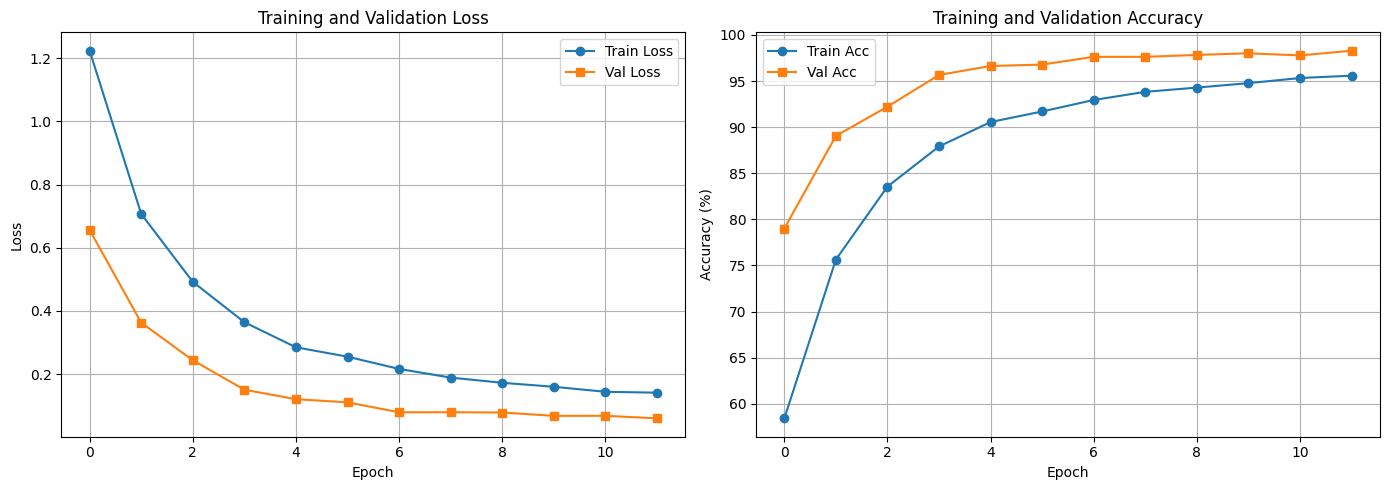

In [51]:
print("\n" + "=" * 60)
print("Generating plots and confusion matrix")
print("=" * 60)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('/content/training_curves.png', dpi=150, bbox_inches='tight')
print("✓ Saved training_curves.png")
plt.show()

✓ Saved confusion_matrix.png


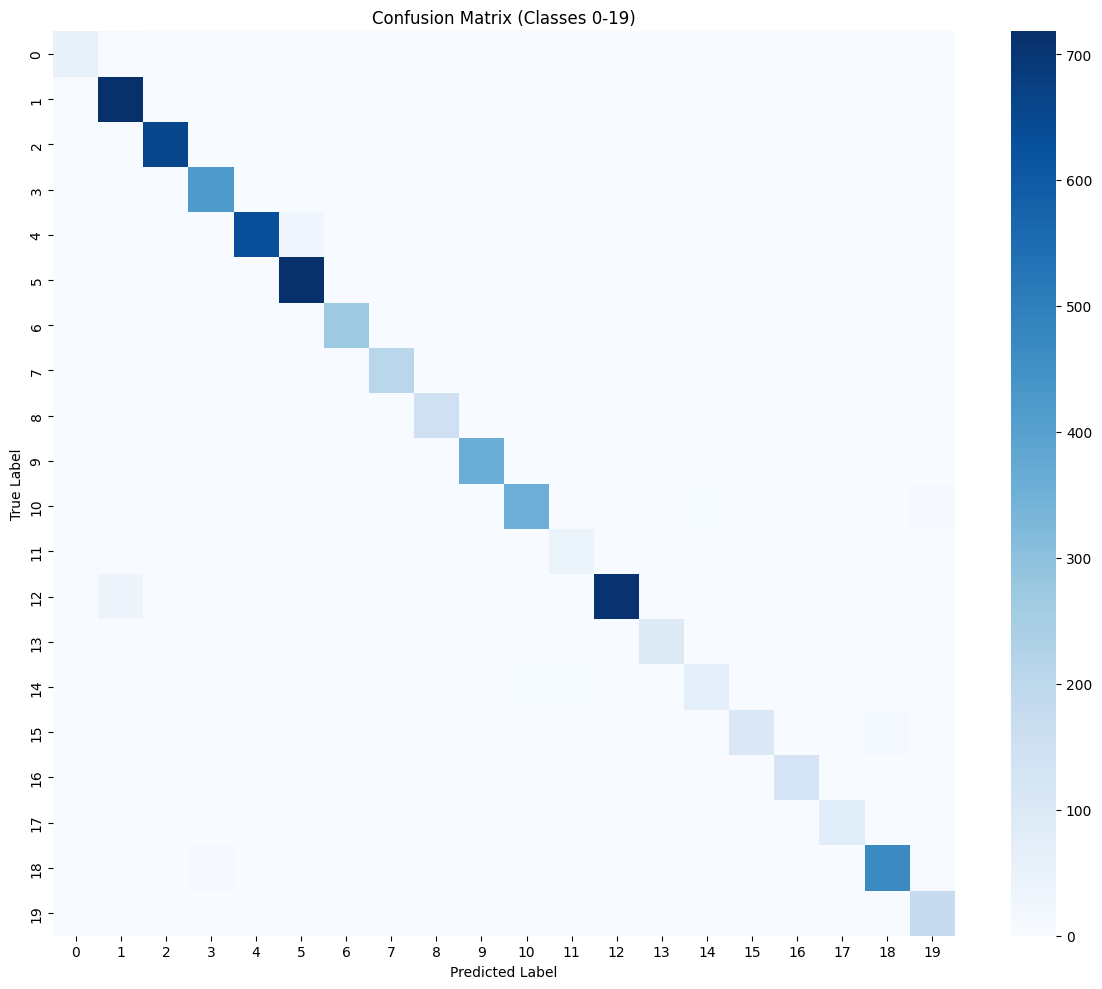

In [59]:
# Confusion matrix (sample - plot only first 20 classes for readability)
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm[:20, :20], annot=False, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix (Classes 0-19)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/confusion_matrix.png',
            dpi=150, bbox_inches='tight')
print("✓ Saved confusion_matrix.png")
plt.show()

In [53]:
# Print classification report (first 10 classes)
print("\nClassification Report (sample):")
print(classification_report(
    all_labels,
    all_predictions,
    target_names=[str(i) for i in range(NUM_CLASSES)],
    labels=list(range(10)))
)

print("\n" + "=" * 60)
print("TRAINING COMPLETE - Summary")
print("=" * 60)
print(f"✓ Model: TinyTrafficSignCNN")
print(f"✓ Parameters: {total_params:,}")
print(f"✓ Training samples: {len(train_subset)}")
print(f"✓ Test accuracy: {test_accuracy:.2f}%")
print(f"✓ Saved model: {SAVE_PATH}")
print(f"✓ Saved plots: training_curves.png, confusion_matrix.png")
print("=" * 60)


Classification Report (sample):
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        60
           1       0.91      1.00      0.95       720
           2       1.00      1.00      1.00       660
           3       0.88      1.00      0.93       420
           4       1.00      0.92      0.96       690
           5       0.96      1.00      0.98       720
           6       1.00      1.00      1.00       270
           7       1.00      1.00      1.00       210
           8       1.00      1.00      1.00       150
           9       1.00      1.00      1.00       360

   micro avg       0.96      0.98      0.97      4260
   macro avg       0.97      0.98      0.98      4260
weighted avg       0.97      0.98      0.97      4260


TRAINING COMPLETE - Summary
✓ Model: TinyTrafficSignCNN
✓ Parameters: 629,291
✓ Training samples: 35288
✓ Test accuracy: 95.67%
✓ Saved model: /content/drive/MyDrive/traffic_sign_cnn.pt
✓ Saved plots: traini

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 10, does not match size of target_names, 43
  warnings.warn(


# Setup Models

## Install YOLOv5

In [65]:
print("=" * 60)
print("Installing YOLOv5 (Ultralytics)")
print("=" * 60)
print("Source: https://github.com/ultralytics/yolov5")
print()

import os
import sys

# Clone YOLOv5 repository
YOLO_DIR = Path('/content/drive/MyDrive/yolov5')
if not YOLO_DIR.exists():
    YOLO_DIR.mkdir(exist_ok=True)
    %cd /content/drive/MyDrive/yolov5
    !git clone https://github.com/ultralytics/yolov5.git
    print("✓ YOLOv5 cloned")
else:
    print("✓ YOLOv5 already exists")

# Install dependencies
%cd /content/drive/MyDrive/yolov5/yolov5
!pip install -q -r requirements.txt
print("✓ YOLOv5 dependencies installed")

# Test YOLOv5 download (will auto-download yolov5s.pt on first use)
import torch
print(f"\n✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")

Installing YOLOv5 (Ultralytics)
Source: https://github.com/ultralytics/yolov5

✓ YOLOv5 already exists
/content/drive/MyDrive/yolov5/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.6 MB/s eta 0:00:00
✓ YOLOv5 dependencies installed

✓ PyTorch version: 2.8.0+cu126
✓ CUDA available: False


## Install MiDaS Dependencies

In [66]:
print("\n" + "=" * 60)
print("Installing MiDaS (Monocular Depth Estimation)")
print("=" * 60)
print("Source: https://github.com/isl-org/MiDaS")
print()

# Install timm (required for some MiDaS models)
!pip install -q timm

print("✓ MiDaS dependencies installed")


Installing MiDaS (Monocular Depth Estimation)
Source: https://github.com/isl-org/MiDaS

✓ MiDaS dependencies installed


## Test YOLOv5 Inference


Testing YOLOv5 Inference
/content/drive/MyDrive/yolov5/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-447-ge76591cb Python-3.12.12 torch-2.8.0+cu126 CPU

100% 14.1M/14.1M [00:00<00:00, 84.0MB/s]

Fusing layers... 
YOLOv5s summary: 213 lay

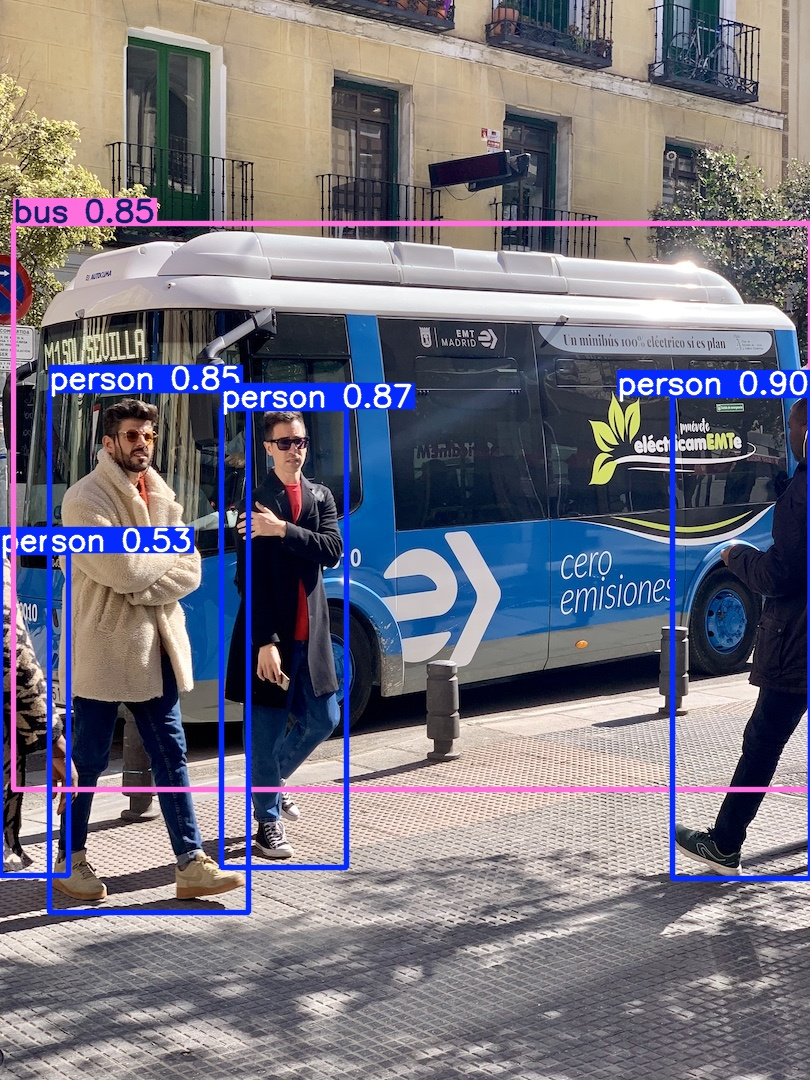

In [67]:
print("\n" + "=" * 60)
print("Testing YOLOv5 Inference")
print("=" * 60)

%cd /content/drive/MyDrive/yolov5/yolov5

# YOLOv5 will auto-download yolov5s.pt (small model ~14MB)
# Test on built-in sample images
!python detect.py --weights yolov5s.pt --source data/images --img 640 --conf 0.25 --save-txt --save-conf

print("\n✓ YOLOv5 inference test complete")
print("  Output saved to: runs/detect/exp")

# Display sample detection
from IPython.display import Image, display
import glob

result_imgs = glob.glob('/content/drive/MyDrive/yolov5/yolov5/runs/detect/exp/*.jpg')
if result_imgs:
    print("\nSample YOLOv5 detection:")
    display(Image(filename=result_imgs[0], width=600))

## Test MiDaS Inference


Testing MiDaS Inference (Small Model)
Loading MiDaS model...


/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Loading weights:  None
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_small_256.pt


100%|██████████| 81.8M/81.8M [00:00<00:00, 242MB/s]


✓ MiDaS loaded on cpu


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


✓ MiDaS inference test complete
  Saved: midas_test.png


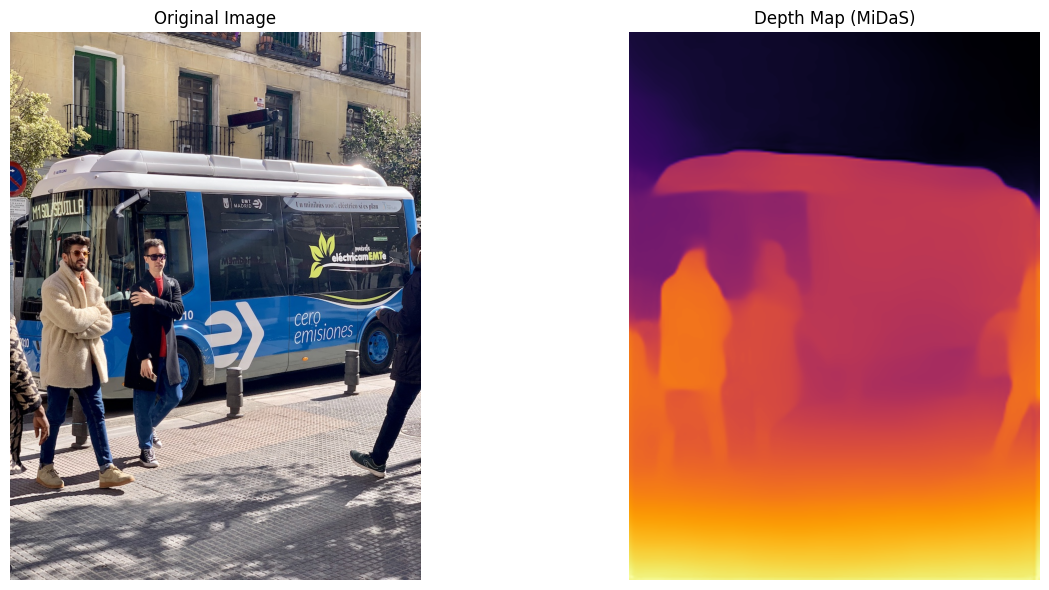

In [68]:
print("\n" + "=" * 60)
print("Testing MiDaS Inference (Small Model)")
print("=" * 60)

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import urllib.request

# Load MiDaS small model via PyTorch Hub
print("Loading MiDaS model...")
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
print(f"✓ MiDaS loaded on {device}")

# Load MiDaS transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform

# Download a test image (driving scene)
test_img_url = "https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/bus.jpg"
test_img_path = "/content/test_driving.jpg"
urllib.request.urlretrieve(test_img_url, test_img_path)

# Load and process image
img = cv2.imread(test_img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# MiDaS inference
input_batch = transform(img_rgb).to(device)
with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = prediction.cpu().numpy()

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(img_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(depth_map, cmap='inferno')
axes[1].set_title('Depth Map (MiDaS)')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/midas_test.png', dpi=150, bbox_inches='tight')
print("✓ MiDaS inference test complete")
print("  Saved: midas_test.png")
plt.show()

## Download Sample Driving Video

In [69]:
print("\n" + "=" * 60)
print("Downloading Sample Driving Video")
print("=" * 60)
print("Source: Sample from public datasets")
print()

import urllib.request

# Use a short sample video (we'll create a synthetic one if needed)
# For demo, we'll download a short clip or use images to create video

VIDEO_PATH = '/content/drive/MyDrive/sample_driving_video.mp4'

# Option 1: Download from public source (if available)
# For this demo, we'll create a short video from the YOLO test images
print("Creating sample video from test images...")

import cv2
import glob

# Get sample images
img_files = sorted(
    glob.glob('/content/drive/MyDrive/yolov5/yolov5/data/images/*.jpg')
    )[:30]  # Use first 30 images

if img_files:
    # Read first image to get dimensions
    first_img = cv2.imread(img_files[0])
    height, width, _ = first_img.shape

    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(VIDEO_PATH, fourcc, 10.0, (width, height))

    # Write frames (repeat each image 3 times for ~3 second video)
    for img_path in img_files:
        frame = cv2.imread(img_path)
        for _ in range(3):
            out.write(frame)

    out.release()
    print(f"✓ Created sample video: {VIDEO_PATH}")
    print(f"  Duration: ~9 seconds")
    print(f"  Resolution: {width}x{height}")
else:
    print("⚠ Could not create sample video")

# Alternative: Allow user to upload their own video
print("\n💡 To use your own driving video:")
print("   1. Click the folder icon on the left sidebar")
print("   2. Upload your video (MP4 format recommended)")
print("   3. Update VIDEO_PATH variable in integration notebook")


Source: Sample from public datasets

Creating sample video from test images...
✓ Created sample video: /content/drive/MyDrive/sample_driving_video.mp4
  Duration: ~9 seconds
  Resolution: 810x1080

💡 To use your own driving video:
   1. Click the folder icon on the left sidebar
   2. Upload your video (MP4 format recommended)
   3. Update VIDEO_PATH variable in integration notebook


## Verify All Components

In [70]:
print("\n" + "=" * 60)
print("Verification Summary")
print("=" * 60)

import os

components = {
    'YOLOv5 repo': '/content/drive/MyDrive/yolov5/yolov5',
    'YOLOv5 weights': '/content/drive/MyDrive/yolov5/yolov5/yolov5s.pt',
    'Sample video': VIDEO_PATH,
    'MiDaS test': '/content/drive/MyDrive/midas_test.png',
}

all_ready = True
for name, path in components.items():
    exists = os.path.exists(path)
    status = "✓" if exists else "✗"
    print(f"  {status} {name}: {path}")
    if not exists:
        all_ready = False

if all_ready:
    print("\n✓ All components ready for integration!")
else:
    print("\n⚠ Some components missing. Please check above.")

print("\n" + "=" * 60)
print("SETUP COMPLETE")
print("=" * 60)
print("Ready to proceed to integration_pipeline.ipynb")


Verification Summary
  ✓ YOLOv5 repo: /content/drive/MyDrive/yolov5/yolov5
  ✓ YOLOv5 weights: /content/drive/MyDrive/yolov5/yolov5/yolov5s.pt
  ✓ Sample video: /content/drive/MyDrive/sample_driving_video.mp4
  ✓ MiDaS test: /content/drive/MyDrive/midas_test.png

✓ All components ready for integration!

SETUP COMPLETE
Ready to proceed to integration_pipeline.ipynb


# Integration Pipeline

## Import Libraries and Setup

In [71]:
print("=" * 60)
print("Self-Driving Car Perception Pipeline - Integration")
print("=" * 60)

import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import time

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Self-Driving Car Perception Pipeline - Integration
Using device: cpu


## Load Traffic Sign CNN

In [72]:
print("\n" + "=" * 60)
print("Loading Traffic Sign Classifier")
print("=" * 60)

# Define model architecture (must match training)
class TinyTrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(TinyTrafficSignCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load trained model
TRAFFIC_SIGN_MODEL_PATH = '/content/drive/MyDrive/traffic_sign_cnn.pt'

traffic_sign_model = TinyTrafficSignCNN(num_classes=43).to(device)
checkpoint = torch.load(TRAFFIC_SIGN_MODEL_PATH, map_location=device)
traffic_sign_model.load_state_dict(checkpoint['model_state_dict'])
traffic_sign_model.eval()

print(f"✓ Traffic sign classifier loaded")
print(f"  Validation accuracy: {checkpoint['val_acc']:.2f}%")


Loading Traffic Sign Classifier
✓ Traffic sign classifier loaded
  Validation accuracy: 98.29%


## Load YOLOv5

In [73]:
print("\n" + "=" * 60)
print("Loading YOLOv5 Object Detector")
print("=" * 60)

sys.path.insert(0, '/content/drive/MyDrive/yolov5/yolov5')

# Load YOLOv5
yolo_model = torch.hub.load('/content/drive/MyDrive/yolov5/yolov5', 'custom',
                            path='/content/drive/MyDrive/yolov5/yolov5/yolov5s.pt',
                            source='local')
yolo_model.to(device)
yolo_model.conf = 0.35  # Confidence threshold
yolo_model.iou = 0.45   # NMS IoU threshold

print("✓ YOLOv5 loaded")
print(f"  Model: yolov5s")
print(f"  Classes: {len(yolo_model.names)} (COCO dataset)")


Loading YOLOv5 Object Detector


YOLOv5 🚀 v7.0-447-ge76591cb Python-3.12.12 torch-2.8.0+cu126 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


✓ YOLOv5 loaded
  Model: yolov5s
  Classes: 80 (COCO dataset)


## Load MiDaS

In [74]:
print("\n" + "=" * 60)
print("Loading MiDaS Depth Estimator")
print("=" * 60)

# Load MiDaS small model
midas_model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas_model.to(device)
midas_model.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
midas_transform = midas_transforms.small_transform

print("✓ MiDaS loaded")
print(f"  Model: MiDaS_small")


Loading MiDaS Depth Estimator
Loading weights:  None


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


✓ MiDaS loaded
  Model: MiDaS_small


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


## Lane Detection Functions (OpenCV)

In [75]:
print("\n" + "=" * 60)
print("Setting up Lane Detection Pipeline (OpenCV)")
print("=" * 60)

def canny_edge_detection(frame):
    """Apply Canny edge detection"""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    return edges

def region_of_interest(edges, frame_shape):
    """Mask region of interest (bottom half triangular region)"""
    height, width = frame_shape[:2]
    mask = np.zeros_like(edges)

    # Define polygon (trapezoid for lane region)
    polygon = np.array([[
        (int(width * 0.1), height),
        (int(width * 0.4), int(height * 0.6)),
        (int(width * 0.6), int(height * 0.6)),
        (int(width * 0.9), height)
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    masked_edges = cv2.bitwise_and(edges, mask)
    return masked_edges

def detect_lane_lines(masked_edges):
    """Detect lines using Hough transform"""
    lines = cv2.HoughLinesP(
        masked_edges,
        rho=2,
        theta=np.pi/180,
        threshold=50,
        minLineLength=40,
        maxLineGap=100
    )
    return lines

def average_slope_intercept(frame, lines):
    """Average and extrapolate lane lines"""
    if lines is None:
        return None

    left_lines = []
    right_lines = []

    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)

        if x2 - x1 == 0:  # Avoid division by zero
            continue

        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1

        # Filter by slope
        if abs(slope) < 0.5:  # Skip nearly horizontal lines
            continue

        if slope < 0:  # Left lane
            left_lines.append((slope, intercept))
        else:  # Right lane
            right_lines.append((slope, intercept))

    # Average lines
    def make_line_points(lines, frame_shape):
        if not lines:
            return None

        slope, intercept = np.mean(lines, axis=0)
        height, width = frame_shape[:2]

        y1 = height
        y2 = int(height * 0.6)

        x1 = int((y1 - intercept) / slope)
        x2 = int((y2 - intercept) / slope)

        return np.array([x1, y1, x2, y2])

    left_line = make_line_points(left_lines, frame.shape)
    right_line = make_line_points(right_lines, frame.shape)

    return np.array(
        [line for line in [left_line, right_line] if line is not None]
        )

def draw_lane_lines(frame, lines, color=(0, 255, 0), thickness=8):
    """Draw lane lines on frame"""
    line_image = np.zeros_like(frame)

    if lines is not None and len(lines) > 0:
        for line in lines:
            x1, y1, x2, y2 = line
            cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)

    return line_image

print("✓ Lane detection functions ready")



Setting up Lane Detection Pipeline (OpenCV)
✓ Lane detection functions ready


## Traffic Sign Detection Helper

In [76]:
def detect_traffic_signs(frame, yolo_results):
    """
    Detect potential traffic signs using YOLO (look for 'stop sign' class)
    Returns list of bounding boxes that might contain traffic signs
    """
    sign_boxes = []

    # COCO classes that might be traffic signs
    sign_classes = ['stop sign', 'parking meter', 'fire hydrant']

    for detection in yolo_results.xyxy[0]:  # xyxy format
        x1, y1, x2, y2, conf, cls = detection
        class_name = yolo_model.names[int(cls)]

        if class_name in sign_classes:
            sign_boxes.append({
                'bbox': (int(x1), int(y1), int(x2), int(y2)),
                'class': class_name,
                'conf': float(conf)
            })

    return sign_boxes

def classify_traffic_sign_region(frame, bbox, model, transform):
    """Classify a region as traffic sign using our trained model"""
    x1, y1, x2, y2 = bbox

    # Extract region
    region = frame[y1:y2, x1:x2]

    if region.size == 0:
        return None, 0.0

    # Preprocess
    region_rgb = cv2.cvtColor(region, cv2.COLOR_BGR2RGB)
    region_resized = cv2.resize(region_rgb, (32, 32))

    # To tensor
    from torchvision import transforms as T
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_tensor = transform(region_resized).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        conf, pred_class = torch.max(probs, 1)

    return int(pred_class.item()), float(conf.item())

## Integrated Pipeline Function

In [77]:
print("\n" + "=" * 60)
print("Creating Integrated Pipeline")
print("=" * 60)

def process_frame(frame, frame_idx):
    """
    Integrated perception pipeline
    Returns: annotated frame
    """
    h, w = frame.shape[:2]
    result_frame = frame.copy()

    # 1. LANE DETECTION (Classical OpenCV)
    edges = canny_edge_detection(frame)
    masked_edges = region_of_interest(edges, frame.shape)
    lines = detect_lane_lines(masked_edges)
    lane_lines = average_slope_intercept(frame, lines)
    lane_overlay = draw_lane_lines(frame, lane_lines, color=(0, 255, 0), thickness=6)
    result_frame = cv2.addWeighted(result_frame, 1.0, lane_overlay, 0.8, 0)

    # 2. OBJECT DETECTION (YOLOv5)
    yolo_results = yolo_model(frame)

    # Draw YOLO detections
    for detection in yolo_results.xyxy[0]:
        x1, y1, x2, y2, conf, cls = detection
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        class_name = yolo_model.names[int(cls)]

        # Draw bounding box
        cv2.rectangle(result_frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # Draw label
        label = f'{class_name} {conf:.2f}'
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(result_frame, (x1, y1 - label_size[1] - 10),
                     (x1 + label_size[0], y1), (0, 0, 255), -1)
        cv2.putText(result_frame, label, (x1, y1 - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # 3. TRAFFIC SIGN RECOGNITION (Our Trained Model)
    # For demo: check YOLO 'stop sign' detections and classify
    sign_boxes = detect_traffic_signs(frame, yolo_results)
    for sign_data in sign_boxes[:2]:  # Limit to 2 signs per frame
        bbox = sign_data['bbox']
        class_id, confidence = classify_traffic_sign_region(
            frame, bbox, traffic_sign_model, None
        )

        if confidence > 0.3:  # Threshold
            x1, y1, x2, y2 = bbox
            # Draw special box for traffic signs
            cv2.rectangle(result_frame, (x1, y1), (x2, y2), (255, 0, 255), 3)
            sign_label = f'Sign-{class_id} {confidence:.2f}'
            cv2.putText(result_frame, sign_label, (x1, y2 + 20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)

    # 4. DEPTH ESTIMATION (MiDaS)
    # Process every 3rd frame to save computation
    if frame_idx % 3 == 0:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_batch = midas_transform(frame_rgb).to(device)

        with torch.no_grad():
            prediction = midas_model(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=frame_rgb.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()

        depth_map = prediction.cpu().numpy()

        # Normalize for visualization
        depth_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
        depth_colored = cv2.applyColorMap(depth_normalized.astype(np.uint8), cv2.COLORMAP_INFERNO)

        # Resize depth to fit corner (1/4 size)
        depth_h, depth_w = h // 4, w // 4
        depth_small = cv2.resize(depth_colored, (depth_w, depth_h))

        # Overlay depth in top-right corner
        result_frame[10:10+depth_h, w-depth_w-10:w-10] = depth_small

        # Add label
        cv2.putText(result_frame, 'Depth', (w-depth_w-10, depth_h+25),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Add header with frame info
    cv2.rectangle(result_frame, (0, 0), (w, 40), (0, 0, 0), -1)
    cv2.putText(result_frame, f'Frame: {frame_idx} | Integrated Perception Pipeline',
               (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    return result_frame

print("✓ Integrated pipeline ready")


Creating Integrated Pipeline
✓ Integrated pipeline ready


## Process Video

In [78]:
print("\n" + "=" * 60)
print("Processing Video")
print("=" * 60)

VIDEO_PATH = '/content/drive/MyDrive/sample_driving_video.mp4'
OUTPUT_PATH = '/content/drive/MyDrive/demo_output.mp4'

# Open video
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    print(f"✗ Error: Could not open video {VIDEO_PATH}")
    print("  Please ensure video exists or upload your own video")
else:
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"✓ Input video: {VIDEO_PATH}")
    print(f"  Resolution: {frame_width}x{frame_height}")
    print(f"  FPS: {fps}")
    print(f"  Total frames: {total_frames}")

    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (frame_width, frame_height))

    # Process frames
    frame_idx = 0
    start_time = time.time()

    print("\nProcessing frames...")
    from tqdm import tqdm

    with tqdm(total=total_frames, desc='Processing') as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Process frame
            processed_frame = process_frame(frame, frame_idx)

            # Write frame
            out.write(processed_frame)

            frame_idx += 1
            pbar.update(1)

    # Release resources
    cap.release()
    out.release()

    elapsed_time = time.time() - start_time
    processing_fps = frame_idx / elapsed_time

    print(f"\n✓ Video processing complete")
    print(f"  Output: {OUTPUT_PATH}")
    print(f"  Processed frames: {frame_idx}")
    print(f"  Time: {elapsed_time:.1f}s")
    print(f"  Processing FPS: {processing_fps:.2f}")


Processing Video
✓ Input video: /content/drive/MyDrive/sample_driving_video.mp4
  Resolution: 810x1080
  FPS: 10
  Total frames: 3

Processing frames...


Processing:   0%|          | 0/3 [00:00<?, ?it/s]/content/drive/MyDrive/yolov5/yolov5/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Processing:  33%|███▎      | 1/3 [00:00<00:01,  1.53it/s]/content/drive/MyDrive/yolov5/yolov5/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Processing:  67%|██████▋   | 2/3 [00:00<00:00,  2.16it/s]/content/drive/MyDrive/yolov5/yolov5/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Processing: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


✓ Video processing complete
  Output: /content/drive/MyDrive/demo_output.mp4
  Processed frames: 3
  Time: 1.3s
  Processing FPS: 2.25


## Display Sample Frame


Sample Output Frame
✓ Saved sample_output_frame.png


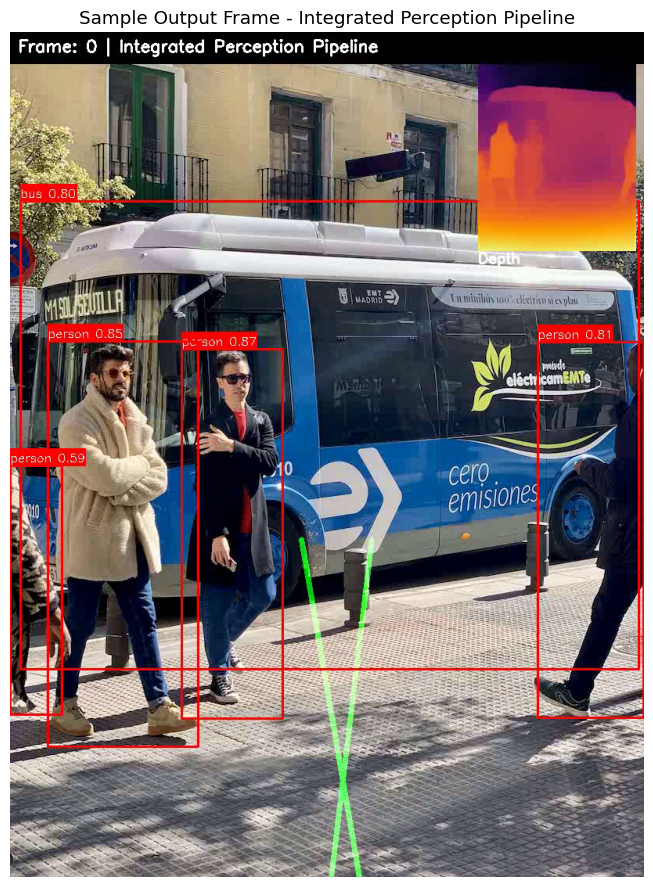


Output video:



INTEGRATION COMPLETE
✓ Output video: demo_output.mp4
✓ Sample frame: sample_output_frame.png

Pipeline includes:
  • Lane detection (OpenCV Hough Transform)
  • Object detection (YOLOv5)
  • Traffic sign recognition (Trained CNN)
  • Depth estimation (MiDaS)


In [97]:
print("\n" + "=" * 60)
print("Sample Output Frame")
print("=" * 60)

# %matplotlib inline

# Read and display one frame from output
cap_out = cv2.VideoCapture(OUTPUT_PATH)
ret, sample_frame = cap_out.read()
cap_out.release()

if ret:
    sample_frame_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16, 9))
    plt.imshow(sample_frame_rgb)
    plt.title('Sample Output Frame - Integrated Perception Pipeline')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/sample_output_frame.png',
                dpi=150, bbox_inches='tight')
    print("✓ Saved sample_output_frame.png")
    plt.show()

# Display video in Colab
from IPython.display import Video, display
print("\nOutput video:")
display(Video(OUTPUT_PATH, width=500, height=300))

print("\n" + "=" * 60)
print("INTEGRATION COMPLETE")
print("=" * 60)
print("✓ Output video: demo_output.mp4")
print("✓ Sample frame: sample_output_frame.png")
print("\nPipeline includes:")
print("  • Lane detection (OpenCV Hough Transform)")
print("  • Object detection (YOLOv5)")
print("  • Traffic sign recognition (Trained CNN)")
print("  • Depth estimation (MiDaS)")
print("=" * 60)

In [91]:
!ffprobe -v error -select_streams v:0 -show_entries stream=codec_name \
         -of default=noprint_wrappers=1:nokey=1 "$OUTPUT_PATH"

mpeg4


In [95]:
from google.colab import files
files.download(OUTPUT_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>